# Resizer_PL_PS_COMPARISION

<img src="images/sd2dram.png" width="650" height="550"/>

In [66]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from pynq import allocate, Overlay
import time

In [67]:
resize_design = Overlay("resizer.bit")

#Then create DMA and Resizer IP objects.
dma = resize_design.axi_dma_0
resizer = resize_design.resize_accel_0

# Load the Image
image_path = "images/fyp_img.png"
original_image = Image.open(image_path)

# Get the width and height
old_width, old_height = original_image.size
print("Image size: {}x{} pixels.".format(old_width, old_height))

# Downsize factor
resize_factor = 2
new_width = int(old_width/resize_factor)
new_height = int(old_height/resize_factor)

# allocate memory to process data on PL
in_buffer = allocate(shape=(old_height, old_width, 3), 
                           dtype=np.uint8, cacheable=1)
out_buffer = allocate(shape=(new_height, new_width, 3), 
                            dtype=np.uint8, cacheable=1)

in_buffer[:] = np.array(original_image)

Image size: 162x226 pixels.


In [68]:
def run_kernel():
    dma.sendchannel.transfer(in_buffer)
    dma.recvchannel.transfer(out_buffer)    
    resizer.write(0x00,0x81) # start
    dma.sendchannel.wait()
    dma.recvchannel.wait()

In [69]:
resizer.register_map.src_rows = old_height
resizer.register_map.src_cols = old_width
resizer.register_map.dst_rows = new_height
resizer.register_map.dst_cols = new_width

In [70]:
%%capture PL_RESULT
%%timeit
run_kernel()
resized_image = Image.fromarray(out_buffer)

In [71]:
del in_buffer
del out_buffer

In [72]:
%%capture PS_RESULT
%%timeit
resized_image_1 = original_image.resize((new_width, new_height), Image.BILINEAR)

FPGA Resizing Time Taken: %s 696 us +- 1.32 us per loop (mean +- std. dev. of 7 runs, 1000 loops each)

Software Resizing Time Taken: %s 1.49 ms +- 1.9 us per loop (mean +- std. dev. of 7 runs, 1000 loops each)

Resizing Factor is 2


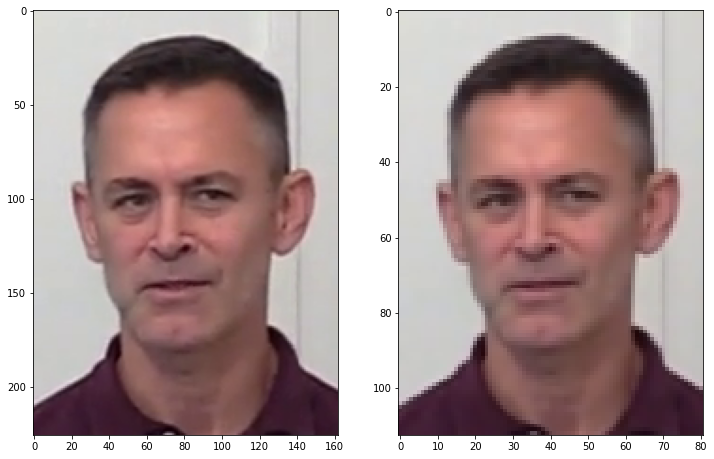

In [76]:
print("FPGA Resizing Time Taken: %s", PL_RESULT)
print("Software Resizing Time Taken: %s", PS_RESULT)
print("Resizing Factor is 2")

fig = plt.figure(figsize=(12, 10));
fig.add_subplot(1, 2, 1)
plt.imshow(original_image)
fig.add_subplot(1, 2, 2)
plt.imshow(resized_image)